In [259]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [260]:
# Standardizing Material Names
df["Material"] = df["Material"].str.strip().str.capitalize()


In [261]:
# Clean column names to avoid hidden spaces
df.columns = df.columns.str.strip()

In [262]:
# Load the CSV file dynamically
df = pd.read_csv("Desktop/Brakepad/brakepad_data.csv")


In [263]:
def categorize_emissions(value):
    value = str(value).strip().lower()  # Convert to lowercase and remove extra spaces
    
    if "low" in value or "minimal dust" in value:
        return 1
    elif "moderate" in value or "co2" in value or "voc" in value or "sulfur dioxide" in value or "nitrogen oxides" in value:
        return 2
    elif "particular" in value or "metal fumes" in value or "particulate matter" in value:
        return 3
    else:
        return 3  # Default to High

df["Emissions Level"] = df["Emissions"].apply(categorize_emissions)


In [264]:
print(df["Emissions"].unique())  # See the actual values in the column


['Particulate matter, VOCs, gaseous emissions, dust and fibres' 'Low'
 'Moderate' 'Particular' 'CO2, particulate matter, sulfur dioxide (SO2)'
 'Carbon dioxide (CO2), particulate matter'
 'Nitrogen oxides (NOx), volatile organic compounds (VOCs)'
 'Metal fumes, CO2' 'CO2, metal oxide particles'
 'Low VOCs, minimal dust emissions'
 'Carbon dioxide, Nitrogen oxides, Particulate matter 10, Sulfur dioxide'
 'Carbon dioxide, Nitrogen oxides, Particulate matter, Metal oxides'
 'Carbon dioxide, Nitrogen oxides, Volatile organic compounds, Particulate matter 2.5'
 'Carbon dioxide, Nitrogen oxides, Volatile organic compounds,']


In [265]:
# Ensuring numeric columns are properly formatted
numeric_cols = ["Width (mm)", "Height (mm)", "Thickness (mm)", "Emissions Level"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")


In [266]:
# Fill missing numeric values with column mean
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())



In [267]:
# Fill missing categorical values with mode
df["Packaging and distribution "] = df["Packaging and distribution "].astype(str).str.strip()
df["Packaging and distribution "] = df["Packaging and distribution "].replace("", df["Packaging and distribution "].mode()[0]).fillna(df["Packaging and distribution "].mode()[0])
df["Recycling or disposal"] = df["Recycling or disposal"].fillna(df["Recycling or disposal"].mode()[0])


In [268]:
print(df[["Packaging and distribution ", "Recycling or disposal"]].isna().sum())


Packaging and distribution     0
Recycling or disposal          0
dtype: int64


In [269]:
# Check if there are any missing values in the DataFrame
missing_values = df.isna().sum()

# Print only columns with missing values (if any)
print("Missing values per column:\n", missing_values[missing_values > 0])


Missing values per column:
 Series([], dtype: int64)


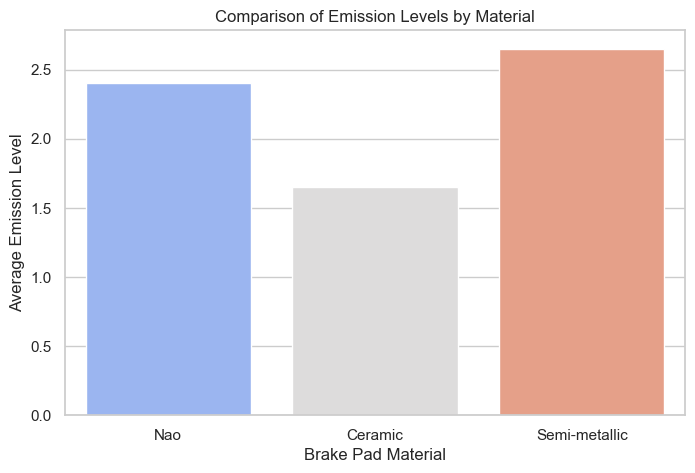

In [270]:
# Set seaborn style for better visuals
sns.set_theme(style="whitegrid")

# Bar plot comparing emission levels by brake pad material
plt.figure(figsize=(8, 5))
sns.barplot(x="Material", y="Emissions Level", hue="Material", 
            data=df_clean, errorbar=None, palette="coolwarm", dodge=False)
plt.xlabel("Brake Pad Material")
plt.ylabel("Average Emission Level")
plt.title("Comparison of Emission Levels by Material")
plt.show()

In [271]:
# Calculate percentage distribution of emissions by material
df_percent = df_clean.groupby("Material")["Emissions Level"].value_counts(normalize=True).mul(100).unstack().fillna(0)
print(df_percent)


Emissions Level          1          2          3
Material                                        
Ceramic          42.307692  50.000000   7.692308
Nao              15.000000  30.000000  55.000000
Semi-metallic     4.347826  26.086957  69.565217


<Figure size 800x500 with 0 Axes>

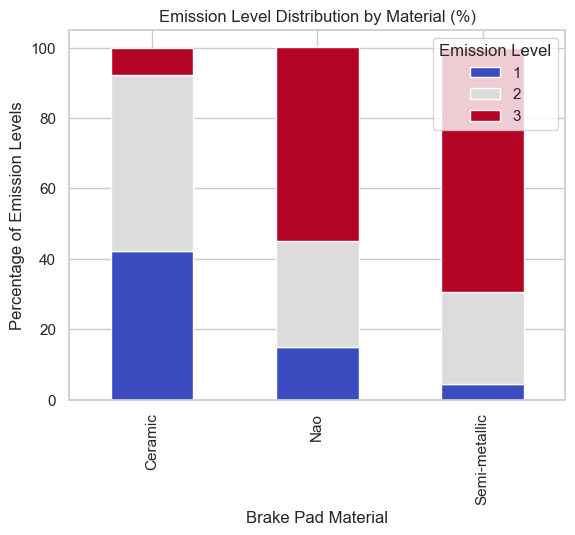

In [272]:
# Plot Emissions Level as Percentages
plt.figure(figsize=(8, 5))
df_percent.plot(kind="bar", stacked=True, colormap="coolwarm")
plt.xlabel("Brake Pad Material")
plt.ylabel("Percentage of Emission Levels")
plt.title("Emission Level Distribution by Material (%)")
plt.legend(title="Emission Level")
plt.show()

In [273]:
# Manufacturing Process Comparison
process_columns = [
    "Raw material acquisition and storage", "Transport and preparation of materials ",
    "Material processing and assembly", "Quality control and inspection processes ",
    "Resource consumption ", "Packaging and distribution ", "Recycling or disposal"
]

# Count non-null entries per material per process
df_process = df_clean.melt(id_vars=["Material"], value_vars=process_columns, var_name="Process", value_name="Description")
df_process_count = df_process.groupby(["Material", "Process"]).count().unstack()

<Figure size 1000x600 with 0 Axes>

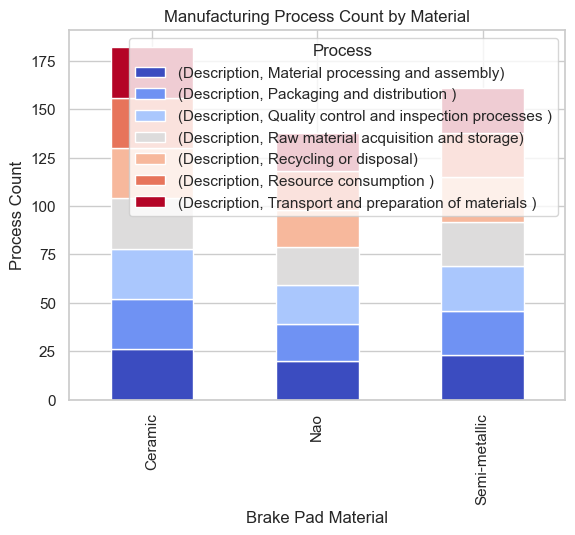

In [274]:
# Plot Manufacturing Process Comparison
plt.figure(figsize=(10, 6))
df_process_count.plot(kind="bar", stacked=True, colormap="coolwarm")
plt.xlabel("Brake Pad Material")
plt.ylabel("Process Count")
plt.title("Manufacturing Process Count by Material")
plt.legend(title="Process")
plt.show()

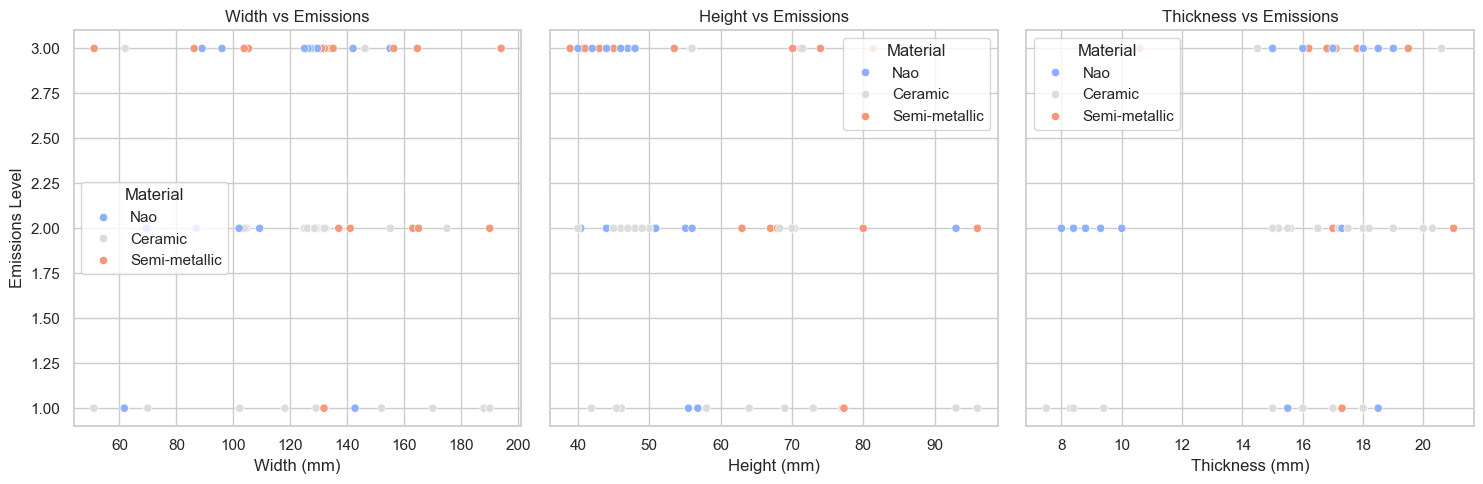

In [275]:
# Scatter plots of dimensions vs emissions
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
sns.scatterplot(ax=axes[0], x="Width (mm)", y="Emissions Level", hue="Material", data=df_clean, palette="coolwarm")
axes[0].set_title("Width vs Emissions")
sns.scatterplot(ax=axes[1], x="Height (mm)", y="Emissions Level", hue="Material", data=df_clean, palette="coolwarm")
axes[1].set_title("Height vs Emissions")
sns.scatterplot(ax=axes[2], x="Thickness (mm)", y="Emissions Level", hue="Material", data=df_clean, palette="coolwarm")
axes[2].set_title("Thickness vs Emissions")
plt.tight_layout()
plt.show()

In [278]:
# Regression Analysis for each material
grouped_regression_results = {}

for material in df["Material"].unique():
    subset = df[df["Material"] == material]
    
    if len(subset) < 2:
        print(f"Skipping regression for {material} (not enough data points)")
        continue  # Skip materials with fewer than 2 rows

    X = subset[["Width (mm)", "Height (mm)", "Thickness (mm)"]]
    y = subset["Emissions Level"]
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    grouped_regression_results[material] = model.summary()
    
    print(f"Regression Results for {material}:\n", model.summary(), "\n")

# Save valid regression results
for material, result in grouped_regression_results.items():
    with open(f"Regression_{material}.txt", "w") as f:
        f.write(str(result))

print("Analysis complete with individual regressions per material type.")


C:\Users\HP\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\HP\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  res = hypotest_fun_out(*samples, **kwds)


Regression Results for NAO:
                             OLS Regression Results                            
Dep. Variable:        Emissions Level   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                 -0.096
Method:                 Least Squares   F-statistic:                    0.4765
Date:                Thu, 27 Mar 2025   Prob (F-statistic):              0.703
Time:                        02:11:36   Log-Likelihood:                -15.943
No. Observations:                  19   AIC:                             39.89
Df Residuals:                      15   BIC:                             43.66
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          

In [279]:
# Save regression results
for material, result in grouped_regression_results.items():
    with open(f"Regression_{material}.txt", "w") as f:
        f.write(str(result))

print("Analysis complete with individual regressions per material type.")

Analysis complete with individual regressions per material type.
